In [1]:
import datetime
import glob
import json
import os
from collections import defaultdict
from pathlib import Path
import traceback
import time
import warnings
import copy
import pathlib

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import urllib
import utils
import warnings

warnings.filterwarnings("ignore")

import input_files.utils

from dask.distributed import LocalCluster, Client, progress, performance_report

# local: single thread, single worker
# cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
# client = Client(cluster)

# for UChicago
# update this to point to your own client!
# client = Client("tls://localhost:8786")

# create a folder for output tracking of uproot.open setup
MEASUREMENT_PATH = pathlib.Path(datetime.datetime.now().strftime("measurements/%Y-%m-%d_%H-%M-%S"))
os.makedirs(MEASUREMENT_PATH)

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.3
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.4.0


In [14]:
mc_file = "https://cernbox.cern.ch/remote.php/dav/public-files/BPIO76iUaeYuhaF/DAOD_PHYSLITE.37233417._000052.pool.root.1"

# download for subsequent use
local_file_name = "ttbar.root"
if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(mc_file, filename=local_file_name)
mc_file
    
# def filter_name(name):
#     return name in [
#         "AnalysisElectronsAuxDyn.pt",
#         "AnalysisElectronsAuxDyn.eta",
#         "AnalysisElectronsAuxDyn.phi",
#         "AnalysisElectronsAuxDyn.m",
        
#         "AnalysisMuonsAuxDyn.pt",
#         "AnalysisMuonsAuxDyn.eta",
#         "AnalysisMuonsAuxDyn.phi",
#         "AnalysisMuonsAuxDyn.m",
        
#         "AnalysisJetsAuxDyn.pt",
#         "AnalysisJetsAuxDyn.eta",
#         "AnalysisJetsAuxDyn.phi",
#         "AnalysisJetsAuxDyn.m",
        
#         "BTagging_AntiKt4EMPFlow.DL1dv01_pb",
#         "BTagging_AntiKt4EMPFlow.DL1dv01_pc",
#         "BTagging_AntiKt4EMPFlow.DL1dv01_pu"
#     ]


# events = NanoEventsFactory.from_root(
#     {local_file_name: "CollectionTree"},
#     schemaclass=PHYSLITESchema,
#     delayed=True,
#     uproot_options=dict(filter_name=filter_name),
# ).events()

events = NanoEventsFactory.from_root(
    {local_file_name: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True
).events()


for string in events.Jets.fields:
    print(string)

pt
_eventindex
eta
phi
m
JetConstitScaleMomentum_pt
JetConstitScaleMomentum_eta
JetConstitScaleMomentum_phi
JetConstitScaleMomentum_m
btaggingLink
ActiveArea4vec_eta
ActiveArea4vec_m
ActiveArea4vec_phi
ActiveArea4vec_pt
DetectorEta
EMFrac
JVFCorr
Timing
NumTrkPt1000
NumTrkPt500
EnergyPerSampling
SumPtChargedPFOPt500
SumPtTrkPt500
TrackWidthPt1000
PSFrac
Width
DFCommonJets_fJvt
HadronConeExclTruthLabelID
HadronConeExclExtendedTruthLabelID
isJvtHS
GhostTrack
PartonTruthLabelID
ConeTruthLabelID
GhostMuonSegmentCount
DFCommonJets_QGTagger_NTracks
DFCommonJets_QGTagger_TracksWidth
DFCommonJets_QGTagger_TracksC1
NNJvtPass


In [24]:
def calculate_jets_btagCSVV2(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    # DDL1 = dak.map_partitions(dask.array.log, DDL1)
    DDL1 = np.log(DDL1)

    return DDL1

In [25]:
jets = events.Jets

jets["btagCSVV2"] = calculate_jets_btagCSVV2(events)

# print(events.Jets.fields)
print(jets.fields)

['pt', '_eventindex', 'eta', 'phi', 'm', 'JetConstitScaleMomentum_pt', 'JetConstitScaleMomentum_eta', 'JetConstitScaleMomentum_phi', 'JetConstitScaleMomentum_m', 'btaggingLink', 'ActiveArea4vec_eta', 'ActiveArea4vec_m', 'ActiveArea4vec_phi', 'ActiveArea4vec_pt', 'DetectorEta', 'EMFrac', 'JVFCorr', 'Timing', 'NumTrkPt1000', 'NumTrkPt500', 'EnergyPerSampling', 'SumPtChargedPFOPt500', 'SumPtTrkPt500', 'TrackWidthPt1000', 'PSFrac', 'Width', 'DFCommonJets_fJvt', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'isJvtHS', 'GhostTrack', 'PartonTruthLabelID', 'ConeTruthLabelID', 'GhostMuonSegmentCount', 'DFCommonJets_QGTagger_NTracks', 'DFCommonJets_QGTagger_TracksWidth', 'DFCommonJets_QGTagger_TracksC1', 'NNJvtPass', 'btagCSVV2']


In [4]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    jets = events.Jets
    jets["btagCSVV2"] = calculate_jets_btagCSVV2(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 < B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag < B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    return ak.flatten(trijet_mass)

In [5]:
reconstructed_top_mass = calculate_trijet_mass(events)


hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375000, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)

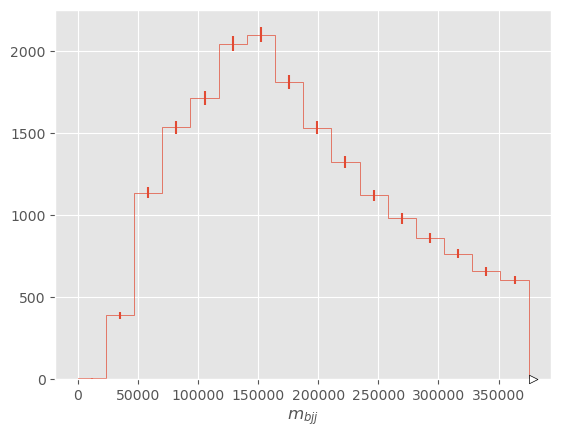

In [6]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

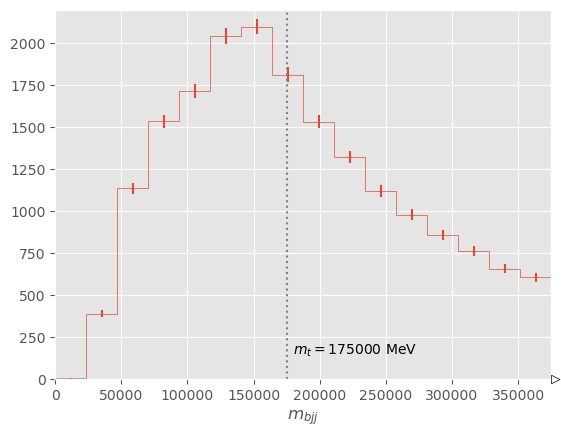

In [7]:
# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175000, 0, 2200, colors=["grey"], linestyle="dotted") 
ax.text(180000, 150, "$m_{t} = 175000$ MeV")
ax.set_xlim([0, 375000])
ax.set_ylim([0, 2200])

fig.savefig(fig_dir / "trijet_mass.png", dpi=300)
fig

In [8]:
B_TAG_THRESHOLD = 2.456

# perform object selection
def object_selection(events):
    elecs = events.Electron
    muons = events.Muon
    jets = events.Jet

    jets["btagCSVV2"] = calculate_jets_btagCSVV2(events)
    
    
    electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
    muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                 (muons.pfRelIso04_all < 0.15))
    jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

    # Only keep objects that pass our requirements
    elecs = elecs[electron_reqs]
    muons = muons[muon_reqs]
    jets = jets[jet_reqs]
    
    
# event selection for 4j1b and 4j2b
def region_selection(elecs, muons, jets):
    ######### Store boolean masks with PackedSelection ##########
    selections = PackedSelection(dtype='uint64')
    # Basic selection criteria
    selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
    selections.add("atleast_4j", ak.num(jets) >= 4)
    selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
    selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
    # Complex selection criteria
    selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
    selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

    return selections.all("4j1b"), selections.all("4j2b")



# observable calculation for 4j2b
def calculate_m_reco_top(jets):
    # reconstruct hadronic top as bjj system with largest pT
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2,
                                    np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass)

    return observable


# create histograms with observables
def create_histograms(events):
    hist_4j1b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="HT", label=r"$H_T$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    hist_4j2b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    process = events.metadata["process"]  # "ttbar" etc.
    variation = events.metadata["variation"]  # "nominal" etc.
    process_label = events.metadata["process_label"]  # nicer LaTeX labels

    # normalization for MC
    x_sec = events.metadata["xsec"]
    nevts_total = events.metadata["nevts"]
    lumi = 3378 # /pb
    if process != "data":
        xsec_weight = x_sec * lumi / nevts_total
    else:
        xsec_weight = 1

    elecs, muons, jets = object_selection(events)

    # region selection
    selection_4j1b, selection_4j2b = region_selection(elecs, muons, jets)

    # 4j1b: HT
    observable_4j1b = ak.sum(jets[selection_4j1b].pt, axis=-1)
    hist_4j1b.fill(observable_4j1b, weight=xsec_weight, process=process_label, variation=variation)

    # 4j2b: m_reco_top
    observable_4j2b = calculate_m_reco_top(jets[selection_4j2b])
    hist_4j2b.fill(observable_4j2b, weight=xsec_weight, process=process_label, variation=variation)

    return {"4j1b": hist_4j1b, "4j2b": hist_4j2b}

In [ ]:
# fileset preparation
N_FILES_MAX_PER_SAMPLE = 1
# compared to coffea 0.7: list of file paths becomes list of dicts (path: trename)
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE)

# fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}  # to only process nominal ttbar
# fileset

In [ ]:
%%time
# pre-process
samples, _ = dataset_tools.preprocess(fileset, step_size=250_000) 
 
# workaround for https://github.com/CoffeaTeam/coffea/issues/1050 (metadata gets dropped, already fixed) 
for k, v in samples.items():
    v["metadata"] = fileset[k]["metadata"]